# Comparing the Python Arch Library and Customized GARCH Implementation

[*********************100%%**********************]  1 of 1 completed
/var/folders/zs/x3llq86s411d8l6j584l0gfw0000gn/T/ipykernel_92051/2436212984.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  var_forecast[t] = omega + alpha * residuals[t-1]**2 + beta * var_forecast[t-1]


Iteration:      1,   Func. Count:      6,   Neg. LLF: 614.4175957369469
Iteration:      2,   Func. Count:     13,   Neg. LLF: 480.2563329154952
Iteration:      3,   Func. Count:     20,   Neg. LLF: 450.5942084617221
Iteration:      4,   Func. Count:     27,   Neg. LLF: 430.23258436823323
Iteration:      5,   Func. Count:     32,   Neg. LLF: 430.22918069683783
Iteration:      6,   Func. Count:     37,   Neg. LLF: 430.2290004161901
Iteration:      7,   Func. Count:     42,   Neg. LLF: 430.22899576063276
Iteration:      8,   Func. Count:     46,   Neg. LLF: 430.22899576061775
Optimization terminated successfully    (Exit mode 0)
            Current function value: 430.22899576063276
            Iterations: 8
            Function evaluations: 46
            Gradient evaluations: 8
Python GARCH Model - MSE: 127.6971, MAE: 7.7695
Customized MLE GARCH Model - MSE: 69.2861, MAE: 6.8378
The better model is: Customized MLE GARCH Model


/var/folders/zs/x3llq86s411d8l6j584l0gfw0000gn/T/ipykernel_92051/2436212984.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  conditional_volatility_mle[t] = omega_mle + alpha_mle * residuals[t-1]**2 + beta_mle * conditional_volatility_mle[t-1]


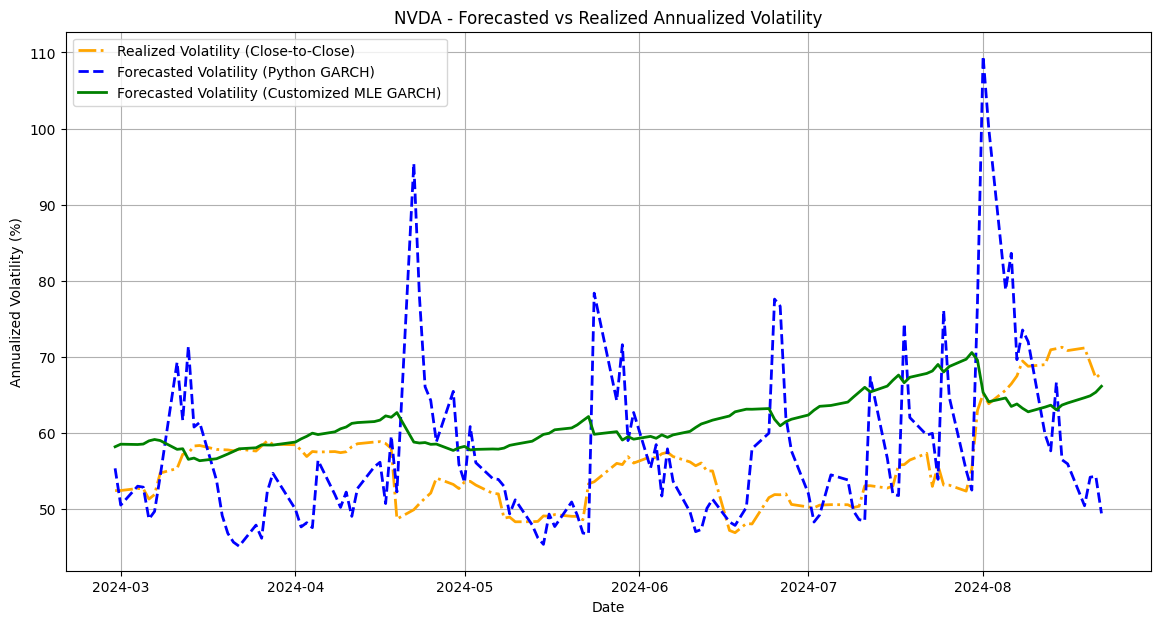

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from arch import arch_model
import scipy.optimize as spop

# 1. Data Preparation
stock_symbol = 'NVDA'
start_date = '2024-01-01'
end_date = '2024-08-23'
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

# Calculate close-to-close returns
returns = 100 * stock_data['Close'].pct_change().dropna()

# Calculate realized volatility using close-to-close returns
def close_to_close_volatility(returns, window=40):
    return returns.rolling(window=window).std()

# Calculate realized volatility over the entire period
realized_volatility_cc = close_to_close_volatility(returns, window=40)
trading_days_per_year = 252
realized_annualized_volatility_cc = realized_volatility_cc * np.sqrt(trading_days_per_year)
realized_annualized_volatility_cc = realized_annualized_volatility_cc.dropna()

# ---- 1. Python-provided GARCH model using the arch package ---- #
garch_model_arch = arch_model(returns, vol='Garch', p=1, q=1)
model_fit_arch = garch_model_arch.fit()

# Extract the conditional volatility from the fitted model
conditional_volatility_arch = model_fit_arch.conditional_volatility
conditional_volatility_annualized_arch = conditional_volatility_arch * np.sqrt(trading_days_per_year)

# ---- 2. Customized MLE-based GARCH model ---- #
# Define the MLE GARCH(1, 1) Log-Likelihood Function
def garch_mle(params):
    mu = params[0]
    omega = params[1]
    alpha = params[2]
    beta = params[3]
    
    residuals = returns - mu
    var_forecast = np.zeros_like(residuals)
    var_forecast[0] = np.var(residuals)
    
    for t in range(1, len(residuals)):
        var_forecast[t] = omega + alpha * residuals[t-1]**2 + beta * var_forecast[t-1]
    
    log_likelihood = -0.5 * (np.log(2 * np.pi) + np.log(var_forecast) + residuals**2 / var_forecast)
    
    return -np.sum(log_likelihood)

# Initial parameters: [mu, omega, alpha, beta]
initial_params = [np.mean(returns), 0.1, 0.1, 0.8]

# Optimize the log-likelihood function
opt_params = spop.minimize(garch_mle, initial_params, method='Nelder-Mead')
mu_mle, omega_mle, alpha_mle, beta_mle = opt_params.x

# Calculate the conditional volatility using the estimated parameters
residuals = returns - mu_mle
conditional_volatility_mle = np.zeros_like(residuals)
conditional_volatility_mle[0] = np.var(residuals)

for t in range(1, len(residuals)):
    conditional_volatility_mle[t] = omega_mle + alpha_mle * residuals[t-1]**2 + beta_mle * conditional_volatility_mle[t-1]

# Annualize the conditional volatility for MLE model
conditional_volatility_annualized_mle = np.sqrt(conditional_volatility_mle) * np.sqrt(trading_days_per_year)

# ---- 3. Model Evaluation ---- #
# Align the lengths of forecasted and realized volatilities
min_length = min(len(conditional_volatility_annualized_arch), len(conditional_volatility_annualized_mle), len(realized_annualized_volatility_cc))
conditional_volatility_trimmed_arch = conditional_volatility_annualized_arch[-min_length:]
conditional_volatility_trimmed_mle = conditional_volatility_annualized_mle[-min_length:]
realized_volatility_trimmed = realized_annualized_volatility_cc[-min_length:]

# Calculate Error Metrics for Python GARCH Model
mse_arch = np.mean((conditional_volatility_trimmed_arch - realized_volatility_trimmed.values) ** 2)
mae_arch = np.mean(np.abs(conditional_volatility_trimmed_arch - realized_volatility_trimmed.values))

# Calculate Error Metrics for Customized MLE GARCH Model
mse_mle = np.mean((conditional_volatility_trimmed_mle - realized_volatility_trimmed.values) ** 2)
mae_mle = np.mean(np.abs(conditional_volatility_trimmed_mle - realized_volatility_trimmed.values))

# Determine the better model
if mse_arch < mse_mle:
    better_model = "Python GARCH Model"
else:
    better_model = "Customized MLE GARCH Model"

# Display the results
print(f'Python GARCH Model - MSE: {mse_arch:.4f}, MAE: {mae_arch:.4f}')
print(f'Customized MLE GARCH Model - MSE: {mse_mle:.4f}, MAE: {mae_mle:.4f}')
print(f'The better model is: {better_model}')

# ---- 4. Visual Comparison ---- #
plt.figure(figsize=(14, 7))
plt.plot(stock_data.index[-min_length:], realized_volatility_trimmed.values, label='Realized Volatility (Close-to-Close)', 
          color='orange', linewidth=2, linestyle='-.')
plt.plot(stock_data.index[-min_length:], conditional_volatility_trimmed_arch, label='Forecasted Volatility (Python GARCH)', 
          color='blue', linewidth=2, linestyle='--')
plt.plot(stock_data.index[-min_length:], conditional_volatility_trimmed_mle, label='Forecasted Volatility (Customized MLE GARCH)', 
          color='green', linewidth=2, linestyle='-')
plt.title(f'{stock_symbol} - Forecasted vs Realized Annualized Volatility')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility (%)')
plt.legend()
plt.grid(True)
plt.show()


# Customized GARCH Forecast

[*********************100%%**********************]  1 of 1 completed
/var/folders/zs/x3llq86s411d8l6j584l0gfw0000gn/T/ipykernel_93630/389376445.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  var_forecast[t] = omega + alpha * residuals[t-1]**2 + beta * var_forecast[t-1]
/var/folders/zs/x3llq86s411d8l6j584l0gfw0000gn/T/ipykernel_93630/389376445.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  conditional_volatility[t] = omega_mle + alpha_mle * residuals[t-1]**2 + beta_mle * conditional_volatility[t-1]


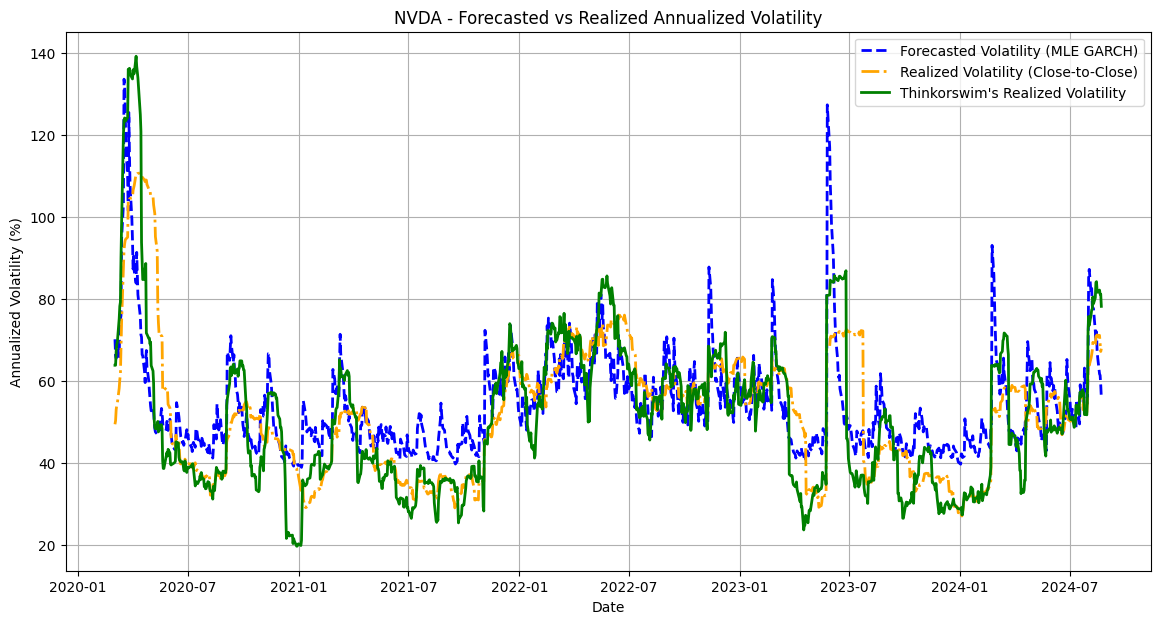

/var/folders/zs/x3llq86s411d8l6j584l0gfw0000gn/T/ipykernel_93630/389376445.py:108: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecasted_volatility[t] = omega_mle + alpha_mle * residuals[-1]**2 + beta_mle * last_volatility


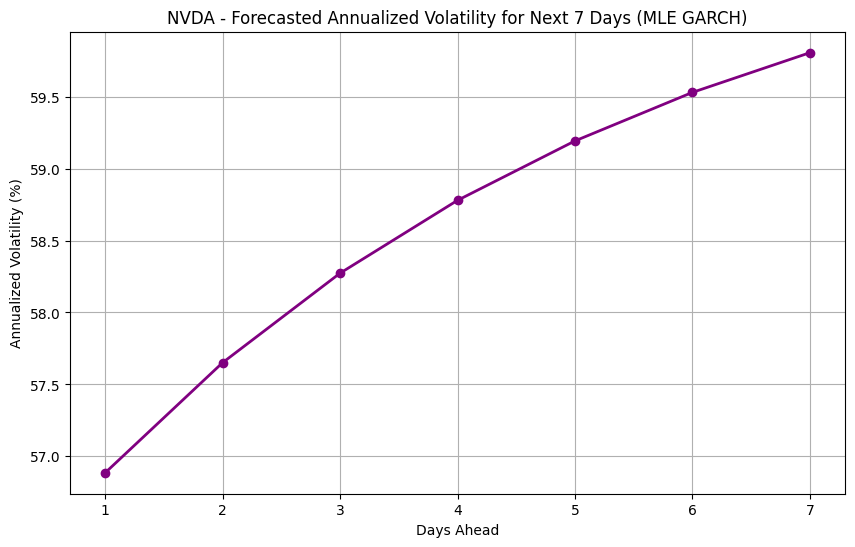

In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.optimize as spop

# 1. Data Preparation
stock_symbol = 'NVDA'
start_date = '2020-01-01'
end_date = '2024-08-23'
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

# Calculate close-to-close returns
returns = 100 * stock_data['Close'].pct_change().dropna()

# Calculate realized volatility using close-to-close returns
def close_to_close_volatility(returns, window=40):
    return returns.rolling(window=window).std()

# Calculate realized volatility over the entire period
realized_volatility_cc = close_to_close_volatility(returns, window=40)

# Annualize the realized volatility
trading_days_per_year = 252
realized_annualized_volatility_cc = realized_volatility_cc * np.sqrt(trading_days_per_year)

# Drop NaN values from the realized volatility
realized_annualized_volatility_cc = realized_annualized_volatility_cc.dropna()

# Calculate Thinkorswim's realized volatility (typically using a 21-day window)
def calculate_thinkorswim_volatility(prices, window=21):
    returns = prices.pct_change().dropna()
    log_returns = np.log(1 + returns)
    volatility = log_returns.rolling(window=window).std() * np.sqrt(252) * 100
    return volatility

# Calculate Thinkorswim's realized volatility over the entire period
thinkorswim_realized_volatility = calculate_thinkorswim_volatility(stock_data['Close'])

# Drop NaN values from Thinkorswim's realized volatility
thinkorswim_realized_volatility = thinkorswim_realized_volatility.dropna()

# GARCH(1, 1) Log-Likelihood Function
def garch_mle(params):
    mu = params[0]
    omega = params[1]
    alpha = params[2]
    beta = params[3]
    
    residuals = returns - mu
    var_forecast = np.zeros_like(residuals)
    var_forecast[0] = np.var(residuals)
    
    for t in range(1, len(residuals)):
        var_forecast[t] = omega + alpha * residuals[t-1]**2 + beta * var_forecast[t-1]
    
    log_likelihood = -0.5 * (np.log(2 * np.pi) + np.log(var_forecast) + residuals**2 / var_forecast)
    
    return -np.sum(log_likelihood)

# Initial parameters: [mu, omega, alpha, beta]
initial_params = [np.mean(returns), 0.1, 0.1, 0.8]

# Optimize the log-likelihood function
opt_params = spop.minimize(garch_mle, initial_params, method='Nelder-Mead')
mu_mle, omega_mle, alpha_mle, beta_mle = opt_params.x

# Calculate the conditional volatility using the estimated parameters
residuals = returns - mu_mle
conditional_volatility = np.zeros_like(residuals)
conditional_volatility[0] = np.var(residuals)

for t in range(1, len(residuals)):
    conditional_volatility[t] = omega_mle + alpha_mle * residuals[t-1]**2 + beta_mle * conditional_volatility[t-1]

# Annualize the conditional volatility
conditional_volatility_annualized = np.sqrt(conditional_volatility) * np.sqrt(trading_days_per_year)

# Align the lengths of forecasted, realized, and Thinkorswim's volatilities
min_length = min(len(conditional_volatility_annualized), len(realized_annualized_volatility_cc), len(thinkorswim_realized_volatility))
conditional_volatility_trimmed = conditional_volatility_annualized[-min_length:]
realized_volatility_cc_trimmed = realized_annualized_volatility_cc[-min_length:]
thinkorswim_volatility_trimmed = thinkorswim_realized_volatility[-min_length:]

# Plotting the Comparison of Volatilities from start_date to end_date
plt.figure(figsize=(14, 7))
plt.plot(stock_data.index[-min_length:], conditional_volatility_trimmed, label='Forecasted Volatility (MLE GARCH)', 
          color='blue', linewidth=2, linestyle='--')
plt.plot(stock_data.index[-min_length:], realized_volatility_cc_trimmed.values, label='Realized Volatility (Close-to-Close)', 
          color='orange', linewidth=2, linestyle='-.')
plt.plot(stock_data.index[-min_length:], thinkorswim_volatility_trimmed.values, label="Thinkorswim's Realized Volatility", 
          color='green', linewidth=2, linestyle='-')
plt.title(f'{stock_symbol} - Forecasted vs Realized Annualized Volatility')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility (%)')
plt.legend()
plt.grid(True)  # Adding grid for better readability
plt.show()

# Set the forecast horizon (number of days ahead)
forecast_horizon = 7  # Adjust this to your desired forecast horizon

# Forecast the next 'forecast_horizon' days of volatility using the MLE GARCH model
forecasted_volatility = np.zeros(forecast_horizon)
last_volatility = conditional_volatility[-1]

for t in range(forecast_horizon):
    forecasted_volatility[t] = omega_mle + alpha_mle * residuals[-1]**2 + beta_mle * last_volatility
    last_volatility = forecasted_volatility[t]

# Annualize the forecasted volatilities
forecasted_volatility_annualized = np.sqrt(forecasted_volatility) * np.sqrt(trading_days_per_year)


# Plotting the Forecasted Volatility for the Next 35 Days
plt.figure(figsize=(10, 6))
plt.plot(range(1, forecast_horizon + 1), forecasted_volatility_annualized, marker='o', color='purple', linewidth=2, linestyle='-')
plt.title(f'{stock_symbol} - Forecasted Annualized Volatility for Next {forecast_horizon} Days (MLE GARCH)')
plt.xlabel('Days Ahead')
plt.ylabel('Annualized Volatility (%)')
plt.grid(True)  # Adding grid for better readability
plt.show()



# Python ARCH Forecast

[*********************100%%**********************]  1 of 1 completed

Iteration:      1,   Func. Count:      6,   Neg. LLF: 614.4175957369469
Iteration:      2,   Func. Count:     13,   Neg. LLF: 480.2563329154952
Iteration:      3,   Func. Count:     20,   Neg. LLF: 450.5942084617221
Iteration:      4,   Func. Count:     27,   Neg. LLF: 430.23258436823323
Iteration:      5,   Func. Count:     32,   Neg. LLF: 430.22918069683783
Iteration:      6,   Func. Count:     37,   Neg. LLF: 430.2290004161901
Iteration:      7,   Func. Count:     42,   Neg. LLF: 430.22899576063276
Iteration:      8,   Func. Count:     46,   Neg. LLF: 430.22899576061775
Optimization terminated successfully    (Exit mode 0)
            Current function value: 430.22899576063276
            Iterations: 8
            Function evaluations: 46
            Gradient evaluations: 8


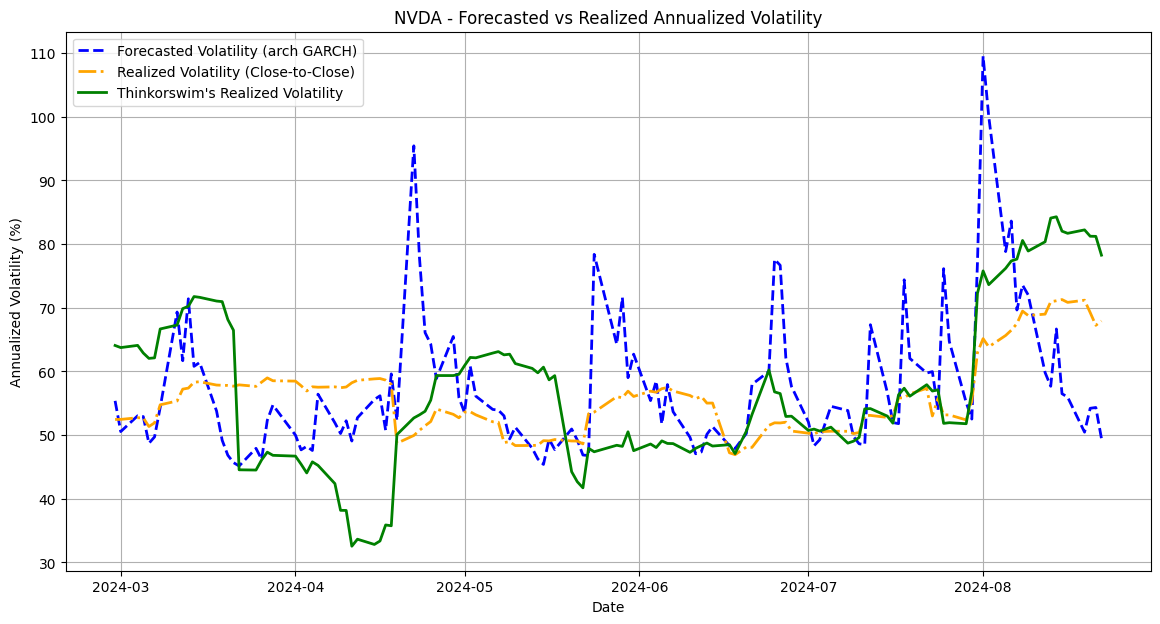

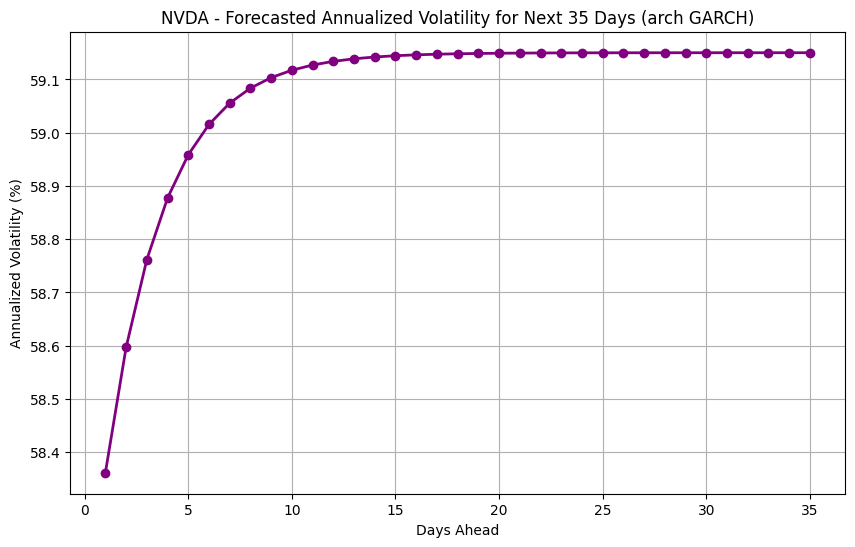

In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from arch import arch_model

# 1. Data Preparation
stock_symbol = 'NVDA'
start_date = '2024-01-01'
end_date = '2024-08-23'
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

# Calculate close-to-close returns
returns = 100 * stock_data['Close'].pct_change().dropna()

# Calculate realized volatility using close-to-close returns
def close_to_close_volatility(returns, window=40):
    return returns.rolling(window=window).std()

# Calculate realized volatility over the entire period
realized_volatility_cc = close_to_close_volatility(returns, window=40)

# Annualize the realized volatility
trading_days_per_year = 252
realized_annualized_volatility_cc = realized_volatility_cc * np.sqrt(trading_days_per_year)

# Drop NaN values from the realized volatility
realized_annualized_volatility_cc = realized_annualized_volatility_cc.dropna()

# Calculate Thinkorswim's realized volatility (typically using a 21-day window)
def calculate_thinkorswim_volatility(prices, window=21):
    returns = prices.pct_change().dropna()
    log_returns = np.log(1 + returns)
    volatility = log_returns.rolling(window=window).std() * np.sqrt(252) * 100
    return volatility

# Calculate Thinkorswim's realized volatility over the entire period
thinkorswim_realized_volatility = calculate_thinkorswim_volatility(stock_data['Close'])

# Drop NaN values from Thinkorswim's realized volatility
thinkorswim_realized_volatility = thinkorswim_realized_volatility.dropna()

# GARCH(1,1) Model using the arch package
garch_model = arch_model(returns, vol='Garch', p=1, q=1)
model_fit = garch_model.fit()

# Extract the conditional volatility from the fitted model
conditional_volatility = model_fit.conditional_volatility

# Annualize the conditional volatility
conditional_volatility_annualized = conditional_volatility * np.sqrt(trading_days_per_year)

# Align the lengths of forecasted, realized, and Thinkorswim's volatilities
min_length = min(len(conditional_volatility_annualized), len(realized_annualized_volatility_cc), len(thinkorswim_realized_volatility))
conditional_volatility_trimmed = conditional_volatility_annualized[-min_length:]
realized_volatility_cc_trimmed = realized_annualized_volatility_cc[-min_length:]
thinkorswim_volatility_trimmed = thinkorswim_realized_volatility[-min_length:]

# Plotting the Comparison of Volatilities from start_date to end_date
plt.figure(figsize=(14, 7))
plt.plot(stock_data.index[-min_length:], conditional_volatility_trimmed, label='Forecasted Volatility (arch GARCH)', 
          color='blue', linewidth=2, linestyle='--')
plt.plot(stock_data.index[-min_length:], realized_volatility_cc_trimmed.values, label='Realized Volatility (Close-to-Close)', 
          color='orange', linewidth=2, linestyle='-.')
plt.plot(stock_data.index[-min_length:], thinkorswim_volatility_trimmed.values, label="Thinkorswim's Realized Volatility", 
          color='green', linewidth=2, linestyle='-')
plt.title(f'{stock_symbol} - Forecasted vs Realized Annualized Volatility')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility (%)')
plt.legend()
plt.grid(True)  # Adding grid for better readability
plt.show()

# Set the forecast horizon (number of days ahead)
forecast_horizon = 35  # Adjust this to your desired forecast horizon

# Forecast the next 'forecast_horizon' days of volatility
forecast = model_fit.forecast(horizon=forecast_horizon)
forecasted_volatility = np.sqrt(forecast.variance.iloc[-1].values) * np.sqrt(trading_days_per_year)

# Plotting the Forecasted Volatility for the Next 'forecast_horizon' Days
plt.figure(figsize=(10, 6))
plt.plot(range(1, forecast_horizon + 1), forecasted_volatility, marker='o', color='purple', linewidth=2, linestyle='-')
plt.title(f'{stock_symbol} - Forecasted Annualized Volatility for Next {forecast_horizon} Days (arch GARCH)')
plt.xlabel('Days Ahead')
plt.ylabel('Annualized Volatility (%)')
plt.grid(True)  # Adding grid for better readability
plt.show()
